# Probability Calibration in KG Embedding
This experiemnt is to investigate which calibration technique is the most suitable one given a dataset and a KG Embedding model.

Within this experiment, we are going to see the performance of 4 typical calibration techniques for 4 KGE models in 3 datasets:
- calibration techniques:
  - Platt Scaling
  - Isotonic Regression
  - Histogram BInning
  - Beta Calibration
- KG Embedding models
  - TransE
  - ComplEx
  - DistMult
  - HoLE
- Datasets
  - FB13k
  - Win11
  - Yago39

In [1]:
import sys
# enable importing the modules from probcalkge
sys.path.append('../')
sys.path.append('../probcalkge')

In [2]:
import importlib
from pprint import pprint
import numpy as np
import pandas as pd

In [67]:

import probcalkge
importlib.reload(probcalkge)
from probcalkge import Experiment, ExperimentResult
from probcalkge import get_calibrators
from probcalkge import get_datasets,  get_kgemodels
from probcalkge import brier_score, negative_log_loss, ks_error, ece

In [87]:
ds = get_datasets()
# from probcalkge.calmodels import get_calibrators
from probcalkge.calmodels2 import get_calibrators
cals = get_calibrators()
kges = get_kgemodels()


WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [89]:
exp = Experiment(
    cals=[cals.uncal, cals.platt, cals.isot, cals.histbin, cals.beta], 
    datasets=[ds.fb13, ds.wn18, ds.yago39, ds.dp50, ds.nations, ds.kinship, ds.umls], 
    kges=[kges.transE, kges.complEx, kges.distMult, kges.hoLE], 
    metrics=[ece]
    )

In [90]:
exp.load_trained_kges('../saved_models/')
# exp.train_kges()

Loaded models:
{'DBpedia50': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x0000025780D86448>,
               'DistMult': <ampligraph.latent_features.models.DistMult.DistMult object at 0x0000025704A89048>,
               'HolE': <ampligraph.latent_features.models.HolE.HolE object at 0x000002570687D0C8>,
               'TransE': <ampligraph.latent_features.models.TransE.TransE object at 0x0000025780892048>},
 'FB13k': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x000002577FDC8A88>,
           'DistMult': <ampligraph.latent_features.models.DistMult.DistMult object at 0x000002574C28B0C8>,
           'HolE': <ampligraph.latent_features.models.HolE.HolE object at 0x0000025704A89108>,
           'TransE': <ampligraph.latent_features.models.TransE.TransE object at 0x000002570687D248>},
 'Kinship': {'ComplEx': <ampligraph.latent_features.models.ComplEx.ComplEx object at 0x0000025780892188>,
             'DistMult': <ampligraph.latent_fea

In [91]:
# exp.cals.append(cals.enir)
exp_res = exp.run_with_trained_kges()
# exp.save_trained_kges('../saved_models/new/')

training various calibrators for TransE on FB13k ...
True
training various calibrators for ComplEx on FB13k ...
True
training various calibrators for DistMult on FB13k ...
True
training various calibrators for HolE on FB13k ...
True
training various calibrators for TransE on WN11 ...
True
training various calibrators for ComplEx on WN11 ...
True
training various calibrators for DistMult on WN11 ...
True
training various calibrators for HolE on WN11 ...
True
training various calibrators for TransE on YAGO39 ...
True
training various calibrators for ComplEx on YAGO39 ...
False
training various calibrators for DistMult on YAGO39 ...
False
training various calibrators for HolE on YAGO39 ...
False
training various calibrators for TransE on DBpedia50 ...
True
training various calibrators for ComplEx on DBpedia50 ...
False
training various calibrators for DistMult on DBpedia50 ...
True
training various calibrators for HolE on DBpedia50 ...
True
training various calibrators for TransE on Natio

In [92]:
exp_res.to_frame()

ExpRes
dataset kge    cal                        metric          
FB13k   TransE UncalCalibrator            ece     0.149351
               PlattCalibrator            ece     0.053682
               IsotonicCalibrator         ece     0.004964
               HistogramBinningCalibrator ece     0.008739
               BetaCalibrator             ece     0.043531
...                                                    ...
UMLS    HolE   UncalCalibrator            ece     0.091528
               PlattCalibrator            ece     0.052620
               IsotonicCalibrator         ece     0.013935
               HistogramBinningCalibrator ece     0.010206
               BetaCalibrator             ece     0.018912

[140 rows x 1 columns]

In [93]:
def res_pivot(exp_res: ExperimentResult) -> pd.DataFrame:
    newdf = exp_res.to_frame().pivot_table(values='ExpRes', index=['dataset', 'kge', 'metric'], columns=['cal'])
    newdf['avg_excl_uncal'] = newdf.loc[:, newdf.columns != 'UncalCalibrator'].mean(axis=1)
    return newdf

newdf = res_pivot(exp_res)

In [97]:
counts = newdf.idxmin(axis=1).value_counts()

<BarContainer object of 4 artists>

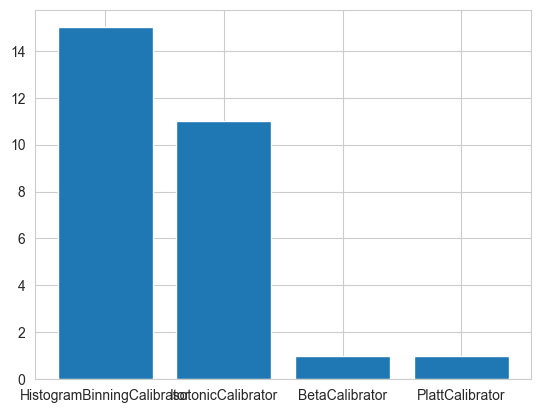

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.bar(x=counts.index, height=counts.values)

[Text(0.5, 0, 'calibrators'), Text(0, 0.5, 'winning counts')]

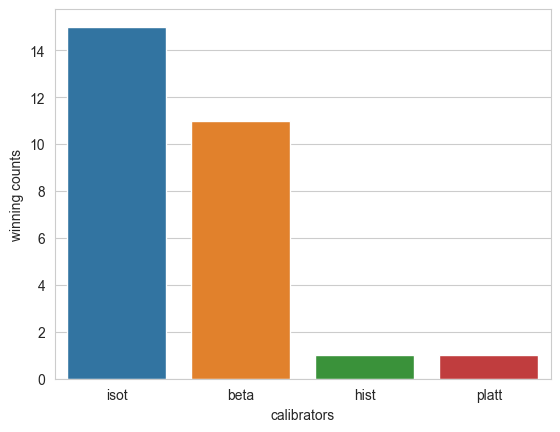

In [99]:
sns.set_style("whitegrid")
gfg = sns.barplot(x=['isot', 'beta', 'hist', 'platt'], y=counts.values)
gfg.set(xlabel ="calibrators", ylabel = "winning counts")

dataset  kge       metric           
FB13k    TransE    brier_score          0.210087
                   negative_log_loss    0.609972
                   ks_error             0.013488
         ComplEx   brier_score          0.218022
                   negative_log_loss    0.624341
                                          ...   
UMLS     DistMult  negative_log_loss    0.311766
                   ks_error             0.025567
         HolE      brier_score          0.091832
                   negative_log_loss    0.309859
                   ks_error             0.014701
Length: 84, dtype: float64